## Generate subset for experiments
- datasets: ultrafeedback, hh

In [1]:
from datasets import load_dataset
from collections import OrderedDict 
import pandas as pd
import numpy as np
import random
import os

random.seed(3)
np.random.seed(3)

def extract_random_susbet(dataset_name, selected_indices, dataset_with_docta_score):

    data_size = len(selected_indices)

    random_indices = np.random.choice(len(dataset_with_docta_score), size=data_size, replace=False)

    random_subset = dataset_with_docta_score.select(random_indices)
    count = 0
    for sample in random_subset:
        if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.1:
            count += 1
            
    print(f"The similar pair proportion in the random subset: {round(count / len(random_subset) * 100, 2)} %")
    random_subset.to_json(f"{dataset_name}_random_subset.json")
    
    print(f"stored data in {dataset_name}_random_subset.json!")

def print_pair_proportion_info(dataset_name, docta_dataset):

    equal_pair_count = 0
    noisy_pair_count = 0
    
    selected_indices = []
    noisy_indices = []
    for idx, sample in enumerate(docta_dataset):
        
        if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.01 or 'similar' == sample['docta_category']:
            equal_pair_count +=1
        else:
            if sample['chosen_docta_score'] < sample['rejected_docta_score']:
                noisy_pair_count +=1
                noisy_indices.append(idx)
            
            selected_indices.append(idx)

    # count / len(docta_dataset['docta_category'])
    # len(docta_dataset['docta_category']) - count
    print(f"## similar pair proportion in the original {dataset_name} dataset: {round(equal_pair_count/len(docta_dataset) * 100, 2)} %")
    print(f"## noisy pair proportion in the original {dataset_name} dataset: {round(noisy_pair_count/len(docta_dataset) * 100, 2)} %")
    print(f"## noisy pair proportion in the selected (non-similar pair) subset: {round(noisy_pair_count/len(selected_indices) * 100, 2)} %")
    print(f"noisy sample counts: {len(noisy_indices)}; selected_indices: {len(selected_indices)} out of original size {len(docta_dataset)}!")
    
    return noisy_indices, selected_indices

def concatenate_docta_score_to_orig_dataset(dataset_name, orig_train_dataset):

    # docta_scores_all = docta_dataset.map(
    #     remove_columns=[name for name in docta_dataset.column_names if name not in ['chosen_docta_score', 'rejected_docta_score']],
    #     desc="Tokenizing and reformatting instruction data",
    # )
    temp = orig_train_dataset.add_column('chosen_docta_score', docta_dataset['chosen_docta_score'])
    dataset_with_docta_score = temp.add_column('rejected_docta_score', docta_dataset['rejected_docta_score'])

    
    return dataset_with_docta_score

def extract_selected_clean_subset(selected_indices, noisy_indices, dataset_with_docta_score):
    
    selected_subset_with_docta_score = dataset_with_docta_score.select(selected_indices)
    selected_subset_with_docta_score.to_json("hh_selected_subset.json")

    def swap_chosen_rejected(example, idx):
        if idx in noisy_indices:
            # 交换 chosen 和 rejected
            example['chosen'], example['rejected'] = example['rejected'], example['chosen']
            
            # 交换 chosen_docta_score 和 rejected_docta_score
            example['chosen_docta_score'], example['rejected_docta_score'] = example['rejected_docta_score'], example['chosen_docta_score']
        
        return example

    #### docta clean subset before selected_indices
    clean_dataset_with_docta_score = dataset_with_docta_score.map(
        swap_chosen_rejected,
        with_indices=True  
    )

    selected_clean_subset_with_docta_score = clean_dataset_with_docta_score.select(selected_indices)
    
    return selected_clean_subset_with_docta_score

def extract_random_subset(data_size, dataset_with_docta_score):

    random_indices = np.random.choice(len(dataset_with_docta_score), size=data_size, replace=False)
    random_subset = dataset_with_docta_score.select(random_indices)
    count = 0
    for sample in random_subset:
        if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.1:
            count += 1
            
    print(f"The similar pair proportion in the random subset: {round(count / len(random_subset) * 100, 2)} %")
    
    return random_subset 


##############################################################################
##############################################################################

dataset_name = 'ultrafeedback' #hh ultrafeedback

print(f"#### dataset_name: {dataset_name} #### \n")
if dataset_name == 'ultrafeedback':
    orig_data_name = "argilla/ultrafeedback-binarized-preferences-cleaned" 
    docta_data_dir = "0093775ultrafeedback_docta.json" 
    
elif dataset_name == 'hh':
    orig_data_name = 'Anthropic/hh-rlhf' 
    docta_data_dir = '2628431hh_all_docta.json'
else:
    raise NotImplementedError

### load data
orig_train_dataset = load_dataset(orig_data_name)['train']
docta_dataset= load_dataset("json", data_files=docta_data_dir)['train']

### statistical information
noisy_indices, selected_indices = print_pair_proportion_info(dataset_name, docta_dataset)

## add docta score to the original dataset
dataset_with_docta_score = concatenate_docta_score_to_orig_dataset(dataset_name, orig_train_dataset)

##generate the selected clean subset/random subset
selected_clean_subset = extract_selected_clean_subset(selected_indices, noisy_indices, dataset_with_docta_score)
random_subset = extract_random_subset(len(selected_indices), dataset_with_docta_score)




# data_path = f'./dataset/'
# if not os.path.exists(data_path):
#     os.makedirs(data_path)


# dataset_with_docta_score.to_json(f"{dataset_name}_with_docta_score.json")
# selected_clean_subset.to_json(data_path + f"{dataset_name}_selected_clean_subset.json")
# random_subset.to_json(data_path + f"{dataset_name}_random_subset.json")

# print(f"stored data in {data_path + dataset_name}_random_subset.json!")
# print(f"stored data in {data_path + dataset_name}_selected_clean_subset.json!")


# ### show several examples
# docta_df = pd.DataFrame(docta_dataset)
# docta_df.head()

/home/jlpang/preference-data-cleaning-tutorial/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### dataset_name: ultrafeedback #### 

## similar pair proportion in the original ultrafeedback dataset: 75.82 %
## noisy pair proportion in the original ultrafeedback dataset: 6.15 %
## noisy pair proportion in the selected (non-similar pair) subset: 25.42 %
noisy sample counts: 3744; selected_indices: 14730 out of original size 60917!


Creating json from Arrow format: 100%|██████████| 15/15 [00:01<00:00, 12.54ba/s]


The similar pair proportion in the random subset: 75.75 %


## Generate a subset with identical pair to illustrate its positive impact.

In [2]:
# dataset_with_docta_score = dataset_with_docta_score.select(range(10))

chosen_docta_scores = dataset_with_docta_score['chosen_docta_score']
rejected_docta_scores = dataset_with_docta_score['rejected_docta_score']


selected_list = []
selected_chosen_scores = []
for idx, sample in enumerate(dataset_with_docta_score):
    # if sample['chosen_docta_score'] ==  sample['rejected_docta_score']:
    if abs(sample['chosen_docta_score'] - sample['rejected_docta_score']) < 0.10:
        selected_chosen_scores
        selected_list.append(idx)

len(selected_list)

46187

In [3]:
from datasets import load_dataset
from collections import OrderedDict 
import pandas as pd
import numpy as np
import random
import os

random.seed(3)
np.random.seed(3)

data_size = 10000

identical_subset = dataset_with_docta_score.select(selected_list)
random_indices = np.random.choice(len(dataset_with_docta_score), size=data_size, replace=False)
random_identical_subset = dataset_with_docta_score.select(random_indices)



# 将列表转换为 numpy 数组（如果它不是 numpy 数组的话）
identical_scores = np.array(identical_subset['chosen_docta_score'])
sorted_idx_desc = np.argsort(identical_scores)[::-1]

# 获取前10000个样本的索引
top_idx = sorted_idx_desc[:data_size]
bottom_idx = sorted_idx_desc[-data_size:]

top_scores = identical_scores[top_idx]
bottom_scores = identical_scores[bottom_idx]

print("random 10000 sample indices:", random_identical_subset['chosen_docta_score'])
print("Top 10000 sample indices:", top_scores)
print("Bottom 10000 sample indices:", bottom_scores)



top_scores_subset = identical_subset.select(top_idx)
bottom_scores_subset = identical_subset.select(bottom_idx)

# random_identical_subset.to_json()
# top_scores_subset.to_json()
# bottom_scores_subset.to_json()


random 10000 sample indices: [0.8160612074, 0.6357189988, 0.7235364325, 0.7286825686, 0.9085510858, 0.9085510858, 0.3557847402, 0.1871206415, 0.5407189988, 0.7256532574, 0.9029635698, 0.7207984302, 0.905, 0.322167913, 0.4047890858, 0.0865368925, 0.6828978284, 0.3025882405, 0.6357189988, 0.5356532574, 0.0923072554, 0.7305422542, 0.9463753132, 0.9964489142, 0.8047188862, 0.6287992477, 0.6708401716, 0.313393208, 0.7152109142, 0.765293758, 0.3075274124, 0.3137907956, 0.9489489142, 0.7673769303, 0.5035510858, 0.4404423432, 0.537167913, 0.9397169111, 0.8610510858, 0.8574528922, 0.854706242, 0.4492700846, 0.5064488661, 0.656395817, 0.4046075883, 0.9525, 0.5854252408, 0.908762, 0.053097826, 0.7174520549, 0.359335826, 0.1847301973, 0.4896038471, 0.6290571412, 0.7711168272, 0.912538329, 0.4442043432, 0.3633272258, 0.3610606391, 0.7183357135, 0.5323130858, 0.2623298888, 0.9014489142, 0.1292131077, 0.5020364302, 0.7718083896, 0.5897336544, 0.2734871062, 0.5430423274, 0.8155142029, 0.9047890858, 0.

In [5]:
identical_subset[0]

{'source': 'evol_instruct',
 'prompt': 'Identify the interrelated economic, political, and social factors that contributed to the stock market crash of 1929, including but not limited to the impact of World War I on the global economy, the role of government policies such as the Smoot-Hawley Tariff Act, the effects of speculative investment practices and margin trading, and the socioeconomic disparities of the time period. Additionally, provide a comparative analysis of the causes and effects of the 1929 stock market crash with other notable financial crises in history, such as the Great Depression of the 1930s and the 2008 global financial crisis. Use primary and secondary sources to support your analysis and provide data visualizations, such as graphs and charts, to illustrate your findings.',
 'chosen': [{'content': 'Identify the interrelated economic, political, and social factors that contributed to the stock market crash of 1929, including but not limited to the impact of World W

In [15]:

identical_scores = np.array(identical_subset['chosen_docta_score'])
sorted_idx_desc = np.argsort(identical_scores)[::-1]

# 获取前10000个样本的索引
top_idx = sorted_idx_desc[:data_size]
bottom_idx = sorted_idx_desc[-data_size:]

top_scores = identical_scores[top_idx]
bottom_scores = identical_scores[bottom_idx]

print("random 10000 sample indices:", random_identical_subset['chosen_docta_score'])
print("Top 10000 sample indices:", top_scores)
print("Bottom 10000 sample indices:", bottom_scores)



top_scores_subset = identical_subset.select(top_idx)
bottom_scores_subset = identical_subset.select(bottom_idx)

random 10000 sample indices: [0.8160612074, 0.6357189988, 0.7235364325, 0.7286825686, 0.9085510858, 0.9085510858, 0.3557847402, 0.1871206415, 0.5407189988, 0.7256532574, 0.9029635698, 0.7207984302, 0.905, 0.322167913, 0.4047890858, 0.0865368925, 0.6828978284, 0.3025882405, 0.6357189988, 0.5356532574, 0.0923072554, 0.7305422542, 0.9463753132, 0.9964489142, 0.8047188862, 0.6287992477, 0.6708401716, 0.313393208, 0.7152109142, 0.765293758, 0.3075274124, 0.3137907956, 0.9489489142, 0.7673769303, 0.5035510858, 0.4404423432, 0.537167913, 0.9397169111, 0.8610510858, 0.8574528922, 0.854706242, 0.4492700846, 0.5064488661, 0.656395817, 0.4046075883, 0.9525, 0.5854252408, 0.908762, 0.053097826, 0.7174520549, 0.359335826, 0.1847301973, 0.4896038471, 0.6290571412, 0.7711168272, 0.912538329, 0.4442043432, 0.3633272258, 0.3610606391, 0.7183357135, 0.5323130858, 0.2623298888, 0.9014489142, 0.1292131077, 0.5020364302, 0.7718083896, 0.5897336544, 0.2734871062, 0.5430423274, 0.8155142029, 0.9047890858, 0.

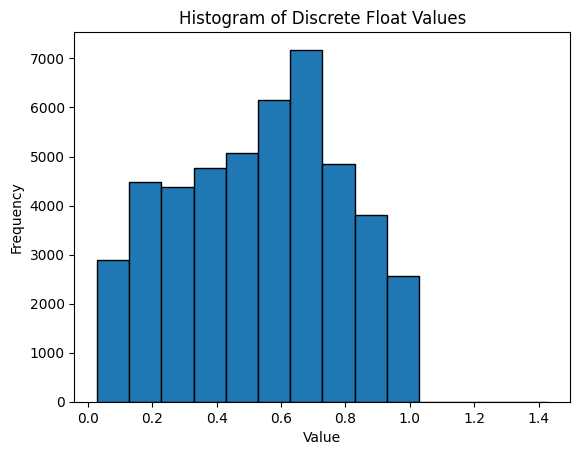

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: floating-point discrete values
data =  identical_subset['chosen_docta_score']

# Define the number of bins or use specific range for float values
bins = np.arange(min(data), max(data) + 0.5, 0.1)  # Adjust step size for your data range

# Plot histogram
plt.hist(data, bins=bins, edgecolor='black')
plt.title('Histogram of Discrete Float Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Generate the KTO dataset

In [54]:
from datasets import load_dataset

kto_dataset = load_dataset("sahandrez/ultrafeedback_kto")['train']

#### remain the chosen one and filter out the rejected one
filter_out_top_set = []
for sample in top_scores_subset:
    
    # filter_out_top_set.append(sample['rejected'][-1]['content'])
    filter_out_top_set.append(sample['prompt'])
    
#### remain the rejected one and filter out the positive one
filter_out_bottom_set = []
for sample in bottom_scores_subset:
    # filter_out_bottom_set.append(sample['chosen'][-1]['content'])
    filter_out_top_set.append(sample['prompt'])


filter_out_samples = filter_out_top_set + filter_out_bottom_set


filter_out_indices = []
# for idx, sample in enumerate(kto_dataset):
#     if sample['completion'][-1]['content'] in set(filter_out_samples):
#         filter_out_indices.append(idx)

# filter_out_indices = [
#     idx for idx, sample in enumerate(kto_dataset)
#     if sample['completion'][-1]['content'] in filter_out_samples
# ]

for idx, sample in enumerate(kto_dataset):
    if sample['prompt'][0]['content'] in set(filter_out_top_set) and sample['label'] == False:
        filter_out_indices.append(idx)
        
    if sample['prompt'][0]['content'] in set(filter_out_bottom_set) and sample['label'] == True:
        filter_out_indices.append(idx)


filtered_kto_dataset = kto_dataset.select([idx for idx in range(len(kto_dataset)) if idx not in filter_out_indices])

from datasets import DatasetDict

new_dataset = DatasetDict({
    'train': filtered_kto_dataset,
    'test': load_dataset("sahandrez/ultrafeedback_kto")['test'],
})

# new_dataset.push_to_hub("ultrafeedback_kto_filtered")

## Convert the KTO samples into SFT form 

- SFT dataset form follows `HuggingFaceH4/ultrachat_200k`

In [23]:
from datasets import load_dataset, Dataset,DatasetDict

kto_dataset = load_dataset("sahandrez/ultrafeedback_kto")['train']


sample_messages = []
prompts = []
prompt_ids = []

for idx, sample in enumerate(kto_dataset):
    sample_prompt = sample['prompt'][0]['content']
    message = [sample['prompt'][0], sample['completion'][0]]
    
    prompts.append(sample_prompt)
    prompt_ids.append(idx)
    sample_messages.append(message)
    
    
sft_kto_train_dataset = Dataset.from_dict({
    'prompt': prompts,
    'prompt_id': prompt_ids,
    'messages': sample_messages
    })

sft_kto_test_dataset = sft_kto_train_dataset.shuffle(seed=42).select(list(range(1000)))


sft_kto_dataset = DatasetDict({
    'train': sft_kto_train_dataset.shuffle(42),
    'test': sft_kto_test_dataset
})

sft_kto_dataset.push_to_hub("jlpang888/ultrafeedback_kto_sft")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_kto_sft/commit/0023ef31a9cbeeadf01b15ed0e26134ca01f7493', commit_message='Upload dataset', commit_description='', oid='0023ef31a9cbeeadf01b15ed0e26134ca01f7493', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/jlpang888/ultrafeedback_kto_sft', endpoint='https://huggingface.co', repo_type='dataset', repo_id='jlpang888/ultrafeedback_kto_sft'), pr_revision=None, pr_num=None)